# **Global Constants**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BDC Datasets"
DATASET_URL = "https://raw.githubusercontent.com/bcgrahn/life-expectancy/main/dataset.csv"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

RANDOM_SEED = 42 # for reproducibility

# **Spark + Google Colab Setup**

## **1.** Install PySpark and related dependencies

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=da479f977fdbf1e7ac4b1718e36d7641ff7be61dbda99582909c3d6ed6c21da0
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

## **2.** Import useful Python packages

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **3.** Create Spark context

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Create <code>ngrok</code> tunnel to check the Spark UI

In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
# get_ipython().system_raw('./ngrok http 4050 &')
# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## **5.** Link Colab to our Google Drive

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **6.** Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.host', '95bc9f04d340'),
 ('spark.app.submitTime', '1685109155179'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.bas

# **The Prediction Task**

In this assignment, worth 15% of your final mark, you will analyse the impact of Sustainable Development
Goals (SDGs) on Life Expectancy. You will collect relevant data from data.worldbank.org, specifically using
the World Development Indicators DataBank for the period of 2000-2016. The dataset provides information
for different countries, and you should only consider low income, lower middle income, and upper middle
income countries by using the provided filter in the DataBank. In this DataBank, the Life Expectancy is
encoded as Life expectancy at birth, total (years). You must use the following SDG
indicators (SDGIs) from this DataBank as features to predict Life Expectancy:
- SDG 1: GNI per capita, PPP (current international $) (NY.GNP.PCAP.PP.CD)
- SDG 2: Prevalence of undernourishment (% of population) (SN.ITK.DEFC.ZS), Food
production index (2014-2016 = 100) (AG.PRD.FOOD.XD)
- SDG 3: Prevalence of HIV, total (% of population ages 15-49) (SH.DYN.AIDS.ZS),
Fertility rate, total (births per woman) (SP.DYN.TFRT.IN)
- SDG 4: School enrollment, primary (% net) (SE.PRM.NENR), School enrollment,
secondary (% net) (SE.SEC.NENR)
- SDG 5: Labor force participation rate, female (% of female population ages
15+) (national estimate) (SL.TLF.CACT.FE.NE.ZS), Proportion of seats held by
women in national parliaments (%) (SG.GEN.PARL.ZS)
- SDG 6: People using at least basic drinking water services (% of population)
- SDG 7: Access to electricity (% of population) (EG.ELC.ACCS.ZS)
- SDG 8: Unemployment with basic education (% of total labor force with basic
education) (SL.UEM.BASC.ZS)
- SDG 11: Urban population (% of total population), Population living in slums
(% of urban population) (EN.POP.SLUM.UR.ZS)
- SDG 12: Population density (people per sq. km of land area) (EN.POP.DNST)
- SDG 13: CO2 emissions (metric tons per capita) (EN.ATM.CO2E.PC)
- SDG 15: Forest area (% of land area) (AG.LND.FRST.ZS)
- SDG 17: Military expenditure (% of GDP) (MS.MIL.XPND.GD.ZS)

The objective is to predict Life Expectancy using SDG indicators as features. You will use PySpark and
Google Colab for data preprocessing, exploratory data analysis, and building basic learning pipelines for
linear regression and random forest regression models. You will also analyse the model parameters and
interpret their significance in relation to the SDGs and their impact on Life Expectancy.

# **1. Data Collection**

This is the first step we need to accomplish before going any further. The dataset will be downloaded directly to our Google Drive, as usual.

### **Download dataset file from URL directly to our Google Drive**

In [ ]:
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200:
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size):
        if block:
          file.write(block)

In [ ]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/bcgrahn/life-expectancy/main/dataset.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/BDC Datasets/dataset.csv


### **Read dataset file into a Spark Dataframe**

In [ ]:
life_df = spark.read.load(GDRIVE_DATASET_FILE,
                         format="csv",
                         sep=",",
                         inferSchema="true",
                         header="true"
                         )

### **Check the shape of the loaded dataset, i.e., number of rows and columns**

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(life_df.count(), len(life_df.columns)))

The shape of the dataset is 2312 rows by 23 columns


### **Print out the schema of the loaded dataset**

In [ ]:
life_df.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Time Code: string (nullable = true)
 |-- Life expectancy at birth, total (years): string (nullable = true)
 |-- GNI per capita, PPP (current international $): string (nullable = true)
 |-- Prevalence of undernourishment (% of population): string (nullable = true)
 |-- Food production index (2014-2016 = 100): string (nullable = true)
 |-- Prevalence of HIV, total (% of population ages 15-49): string (nullable = true)
 |-- Fertility rate, total (births per woman): string (nullable = true)
 |-- School enrollment, secondary (% net): string (nullable = true)
 |-- School enrollment, primary (% net): string (nullable = true)
 |-- Labor force participation rate, female (% of female population ages 15+) (national estimate): string (nullable = true)
 |-- Proportion of seats held by women in national parliaments (%): string (nullable = true)
 |-- People using at l

### **Display the first 5 rows of the dataset**

In [ ]:
life_df.show(5)

+------------+------------+----+---------+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+------------------------------------+----------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------+-------------------------------------------------------------------------------+----------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+
|Country Name|Country Code|

# **2. Data Preprocessing**



Since we are evaluating the impact of SDGS on life expectancy, Country Name and Time, and their corresponding redundant features Country code and Time code should be dropped

In [ ]:
# Drop the "Time code" and "Country code" columns
life_df = life_df.drop("Time code", "Country code", "Country Name", "Time")

The data anaylsis section requires that numerical features are of type int or float. This is necessary for line graphs, box plots, etc and so we will perform the conversion here


In [ ]:
# Convert numerical features from string to float, int (This will also replace the empty entries with null)
FLOAT_FEATURES = ["Life expectancy at birth, total (years)","GNI per capita, PPP (current international $)","Prevalence of undernourishment (% of population)", "Food production index (2014-2016 = 100)",
                      "Prevalence of HIV, total (% of population ages 15-49)","Fertility rate, total (births per woman)","School enrollment, secondary (% net)","School enrollment, primary (% net)",
                      "Labor force participation rate, female (% of female population ages 15+) (national estimate)","Proportion of seats held by women in national parliaments (%)","People using at least basic drinking water services (% of population)",
                      "Access to electricity (% of population)","Unemployment with basic education (% of total labor force with basic education)","Urban population (% of total population)","Population living in slums (% of urban population)",
                      "Population density (people per sq km of land area)","CO2 emissions (metric tons per capita)","Forest area (% of land area)","Military expenditure (% of GDP)"
                      ]
INT_FEATURES = ["Time"]

for feature in FLOAT_FEATURES:
    if feature in life_df.columns:
        life_df = life_df.withColumn(feature, col(feature).cast("float"))

for feature in INT_FEATURES:
    if feature in life_df.columns:
        life_df = life_df.withColumn(feature, col(feature).cast("int"))


### **Check for any missing values**

In [ ]:
for c in life_df.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, life_df.where(col(c).isNull()).count()))

N. of missing values of column `Life expectancy at birth, total (years)` = 32
N. of missing values of column `GNI per capita, PPP (current international $)` = 137
N. of missing values of column `Prevalence of undernourishment (% of population)` = 568
N. of missing values of column `Food production index (2014-2016 = 100)` = 87
N. of missing values of column `Prevalence of HIV, total (% of population ages 15-49)` = 476
N. of missing values of column `Fertility rate, total (births per woman)` = 30
N. of missing values of column `School enrollment, secondary (% net)` = 1349
N. of missing values of column `School enrollment, primary (% net)` = 913
N. of missing values of column `Labor force participation rate, female (% of female population ages 15+) (national estimate)` = 1289
N. of missing values of column `Proportion of seats held by women in national parliaments (%)` = 195
N. of missing values of column `People using at least basic drinking water services (% of population)` = 38
N. of 

If removing the null entries for a feature will result in the loss of >50% of the data than that feature should be removed as stated in a kaggle article here https://www.kaggle.com/general/248836. 50% of 2312 entries is 1156 and thus these features ought to be removed:
1. Unemployment with basic education (% of total labor force with basic education)
2. Population living in slums (% of urban population)
3. School enrollment, secondary (% net)
4.  Labor force participation rate, female (% of female population ages 15+) (national estimate).

However the null entries do not always coincide with null entries from other features. In other words they don't always over lap. This means that even when features 1 to 4 are removed and the max number of null entries for a given feature is now 913, removing the null entries is almost gauranteed to result in the removal of >913 entries thoughout the entire dataset. Thus it will be necessary to remove more features to ensure that the loss of data is less than 50%. Additional features to be removed:
5. School enrollment, primary (% net)

Ideally we need to make sure we have atleast one feature for each SGD, however the first feature mentioned to be dropped is the only one for SDG 8. 1627 is still to large a value and thus will still be dropped. Feature 2 is one of two features for SDG 11. Feature 3 and 5 are two of two for SD4 and Feature 2 is one of two.


In [ ]:
#Drop features with >50% null values
dataset_df = life_df.drop("Unemployment with basic education (% of total labor force with basic education)", "Population living in slums (% of urban population)", "School enrollment, secondary (% net)", "Labor force participation rate, female (% of female population ages 15+) (national estimate)")

In [ ]:
#Drop more features to ensure that less than 50% of all entries is lost
dataset_df = dataset_df.drop("School enrollment, primary (% net)")

In [ ]:
# Drop entries with null values
dataset_df = dataset_df.na.drop()

In [ ]:
dataset_df.show(10)

+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------+----------------------------------------+--------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+
|Life expectancy at birth, total (years)|GNI per capita, PPP (current international $)|Prevalence of undernourishment (% of population)|Food production index (2014-2016 = 100)|Prevalence of HIV, total (% of population ages 15-49)|Fertility rate, total (births per woman)|Proportion of seats held by women in national parliaments (%)|People using at least basic dri

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(dataset_df.count(), len(dataset_df.columns)))

The shape of the dataset is 1215 rows by 14 columns


A total of 1097 entries were dropped resulting in a loss of 47.44 % which meets the <50% requirement we defined above

# **3. Exploratory data analysis**

Before starting with the application of any (linear regression) modeling technique, a good practice is to first take a look at a few statistics computed from the data. These include a regression plot for linearity, a heatmap for correlation and feature selection for determination of the best features ranked from best to worst

In [ ]:
# Let's define some constants which we will use throughout this notebook
NUMERICAL_FEATURES = ["GNI per capita, PPP (current international $)","Prevalence of undernourishment (% of population)", "Food production index (2014-2016 = 100)",
                      "Prevalence of HIV, total (% of population ages 15-49)","Fertility rate, total (births per woman)",
                      "Proportion of seats held by women in national parliaments (%)","People using at least basic drinking water services (% of population)",
                      "Access to electricity (% of population)","Urban population (% of total population)",
                      "Population density (people per sq km of land area)","CO2 emissions (metric tons per capita)","Forest area (% of land area)","Military expenditure (% of GDP)"
                      ]
TARGET_VARIABLE = "Life expectancy at birth, total (years)"

### **Summary of Descriptive Statistics**

In [ ]:
life_df.describe().show()

+-------+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+------------------------------------+----------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------+-------------------------------------------------------------------------------+----------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+
|summary|Life expectancy at birth, total (years)|GNI per cap

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
life_pdf = dataset_df.toPandas()

In [ ]:
# Set some default plotting configuration using seaborn properties
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2,
                                "xtick.labelsize":14,
                                "ytick.labelsize":14,
                                "axes.labelsize": 18
                                })

### **Relationship between _numerical features_ and the _target variable_ (`Life expectancy at birth, total (years)`)**

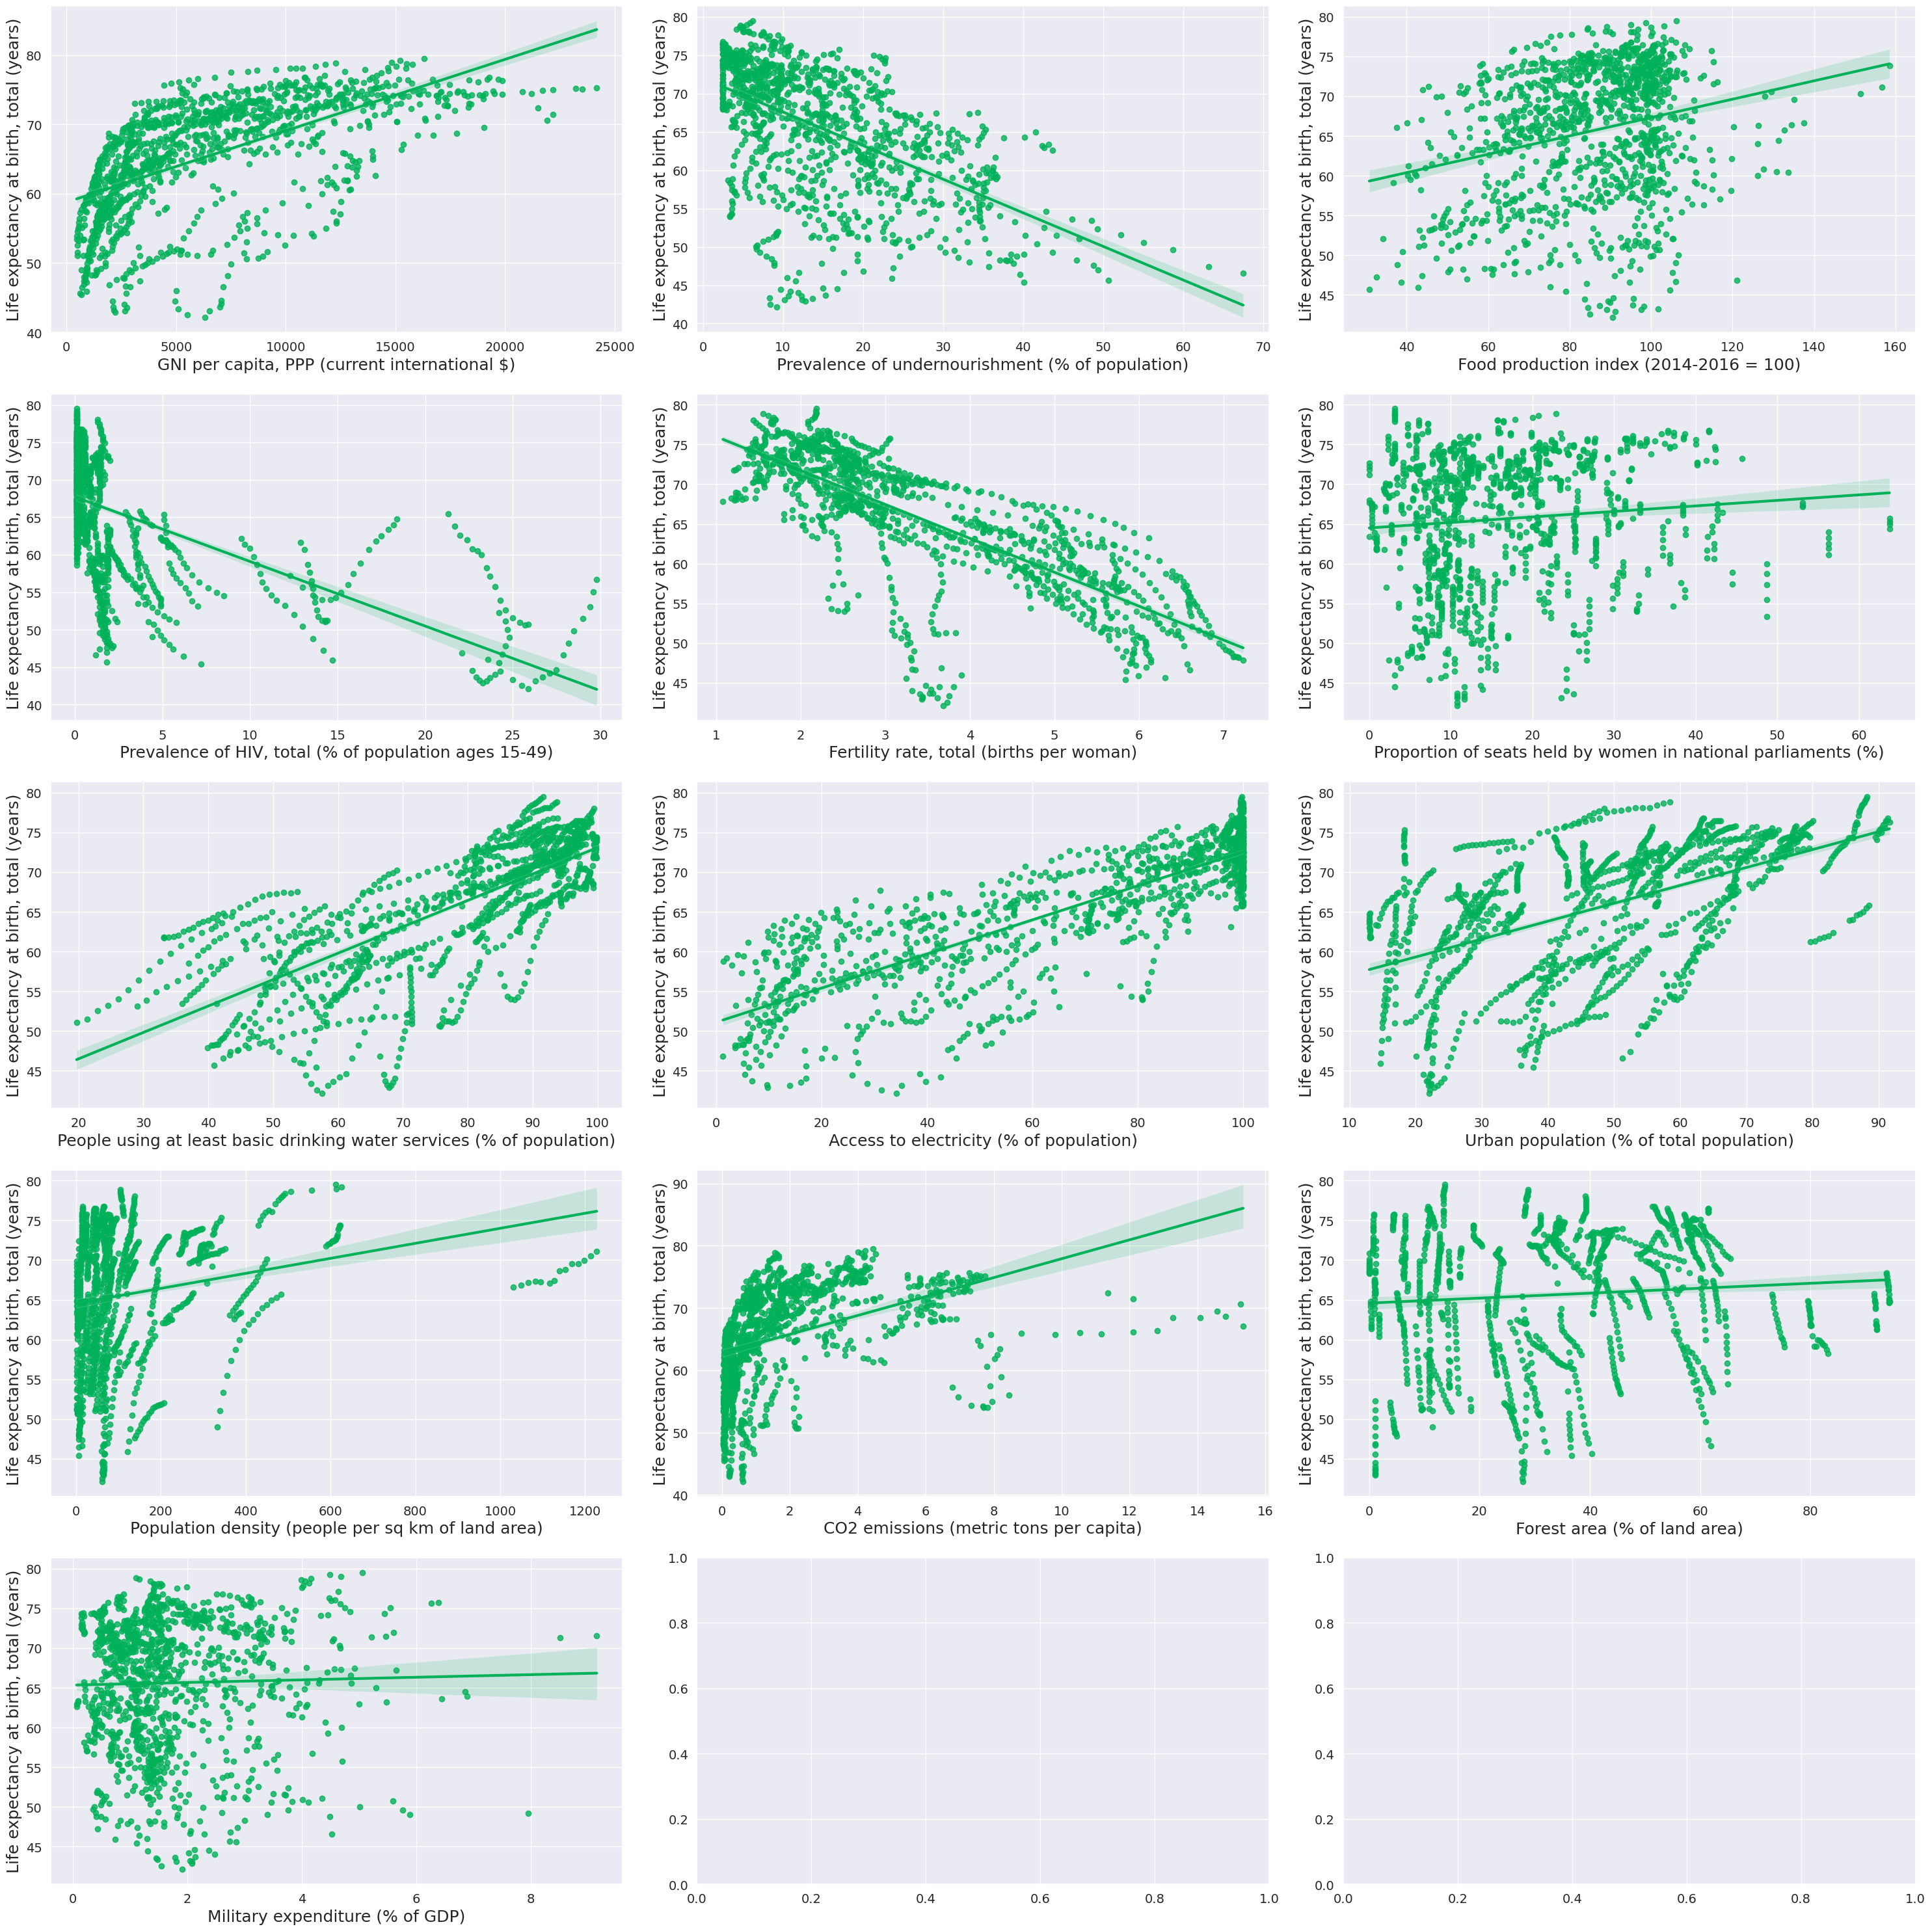

In [ ]:
# Plot the relationship between each continuous feature (i.e., independent variable) with the target (i.e., dependent) variable
n_rows = 5
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30,30))

for i,f in enumerate(NUMERICAL_FEATURES):
  _ = sns.regplot(data=life_pdf,
                  x=f,
                  y="Life expectancy at birth, total (years)",
                  color="#00b159",
                  ax=axes[i//n_cols, i%n_cols])

fig.tight_layout(pad=1.5)

#### **Observations**
A linear relationship allows for straightforward interpretation of the coefficients in the linear regression model. The coefficients represent the change in the target variable associated with a one-unit change in the feature, providing meaningful insights into the relationship between the variables. If the relationship is indeed linear, the model can be used for extrapolation beyond the observed data range. This can be useful for making predictions or estimates for feature values that were not present in the training data.

Features 'Access to electricity (% of population)', 'People using at least basic drinking water services (% of population)', 'Fertility rate, total (births per woman)' have the best linear relationship with the life expectancy. Features 'Forest area (% of land area)', 'Military expenditure (% of GDP)' have the worst.
Note that Population density (people per sq km of land area) has outliers that should be removed but this is outside the scope of this assignment. In summary we should test if removing the two worst features mentioned above improves the model

### **Pearson Correlation Coefficient and Correlation Matrix**

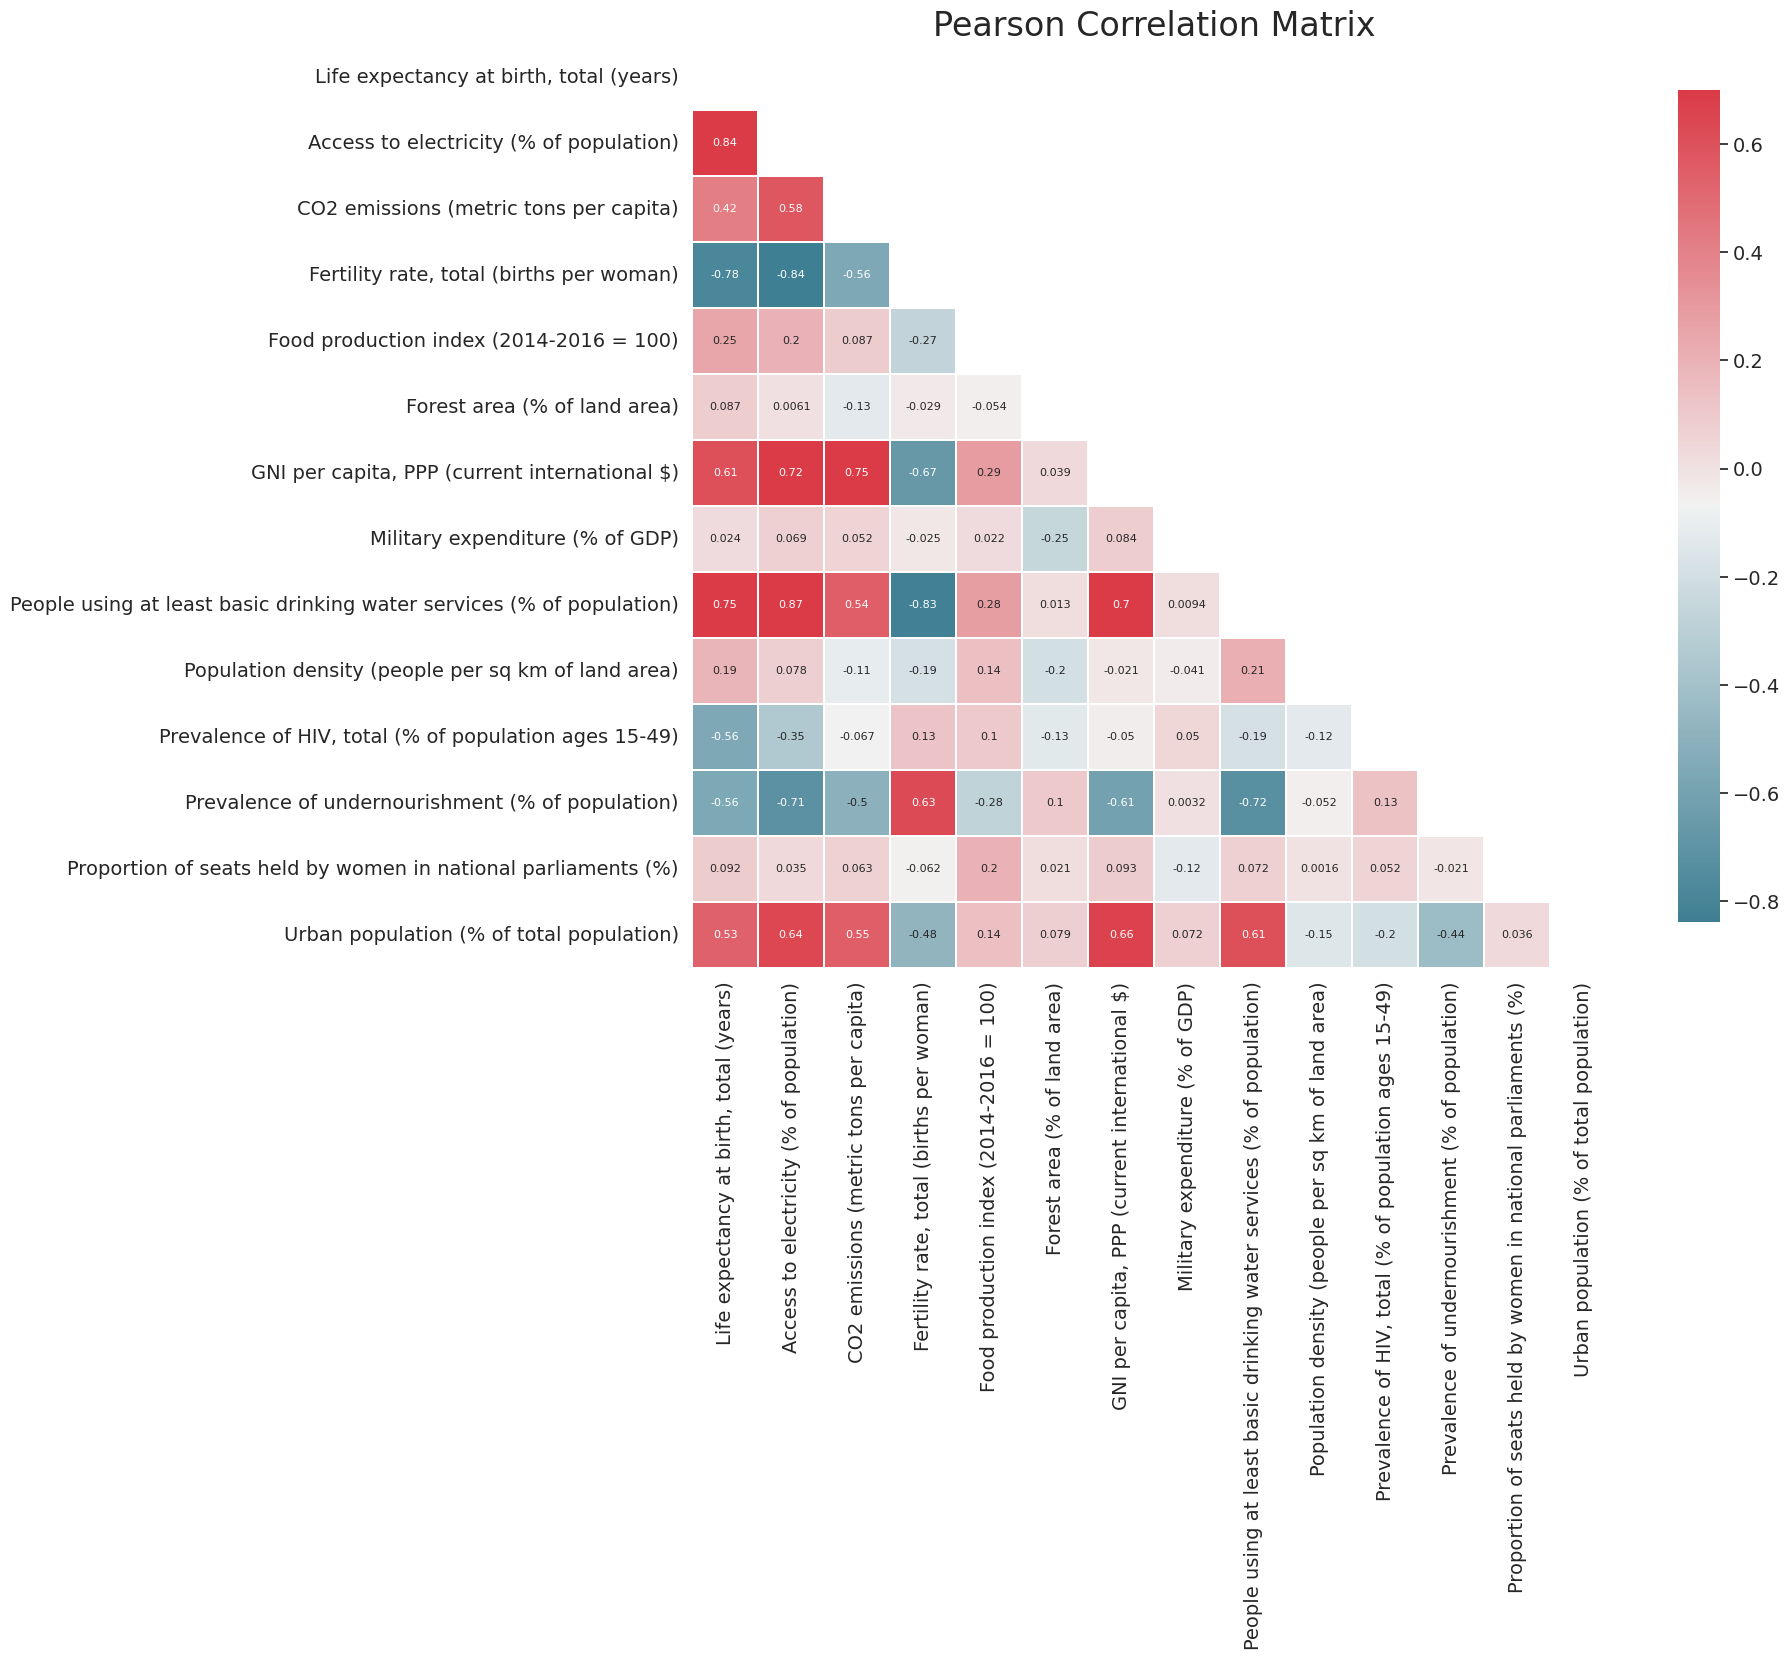

In [ ]:
# Select the features we want to use to compute the correlation matrix (i.e., everything except `id` and `date`)
features = [TARGET_VARIABLE] + sorted(NUMERICAL_FEATURES)

mask = np.zeros_like(life_pdf[features].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"): # Temporarily set the background to white
  fig, ax = plt.subplots(figsize=(16, 12))
  plt.title('Pearson Correlation Matrix', fontsize=24)

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  _ = sns.heatmap(life_pdf[features].corr(),
              linewidths=0.25,
              vmax=0.7,
              square=True,
              ax=ax,
              cmap=cmap,
              linecolor='w',
              annot=True,
              annot_kws={"size":8},
              mask=mask,
              cbar_kws={"shrink": .9});

#### **Observations**
A heatmap provides a visual representation of the correlation between features. It allows us to identify which features are strongly correlated with each other and which ones have a weaker or no correlation

The model might be negatively impacted if there exists very high **correlation** between a subset of features, as keeping all of them most of the time will cause overfitting. If two features are highly correlated there is no reason to keep them both, as one can be easily derived from the other and together they do not add any valuable predictive power to our model.

However, this does not mean that we must _always_ remove one of the highly correlated features. In some cases, even if two features are highly correlated they still may capture different aspects of the domain objects.

`Access to electricity (% of population)` and `People using at least basic drinking water services (% of population)` are high-positively correlated with each other ($\rho = 0.87$). This seems legitimate, as more electricity = more C02 emmitions from power plants, cars, etc. We could remove either feature and it should not have a signficant impact on the models performace. However these features capture different aspects of the domain objects and thus can and should be kept.

The Feature `Fertility rate` has the lowest correlation ($\rho = -0.78$) with the target value. It might be beneficial to remove this feature however it has a strong linear relationship and thus should be kept

Features `Access to electricity (% of population)`, `GNI per capita, PPP (current international $)`, `People using at least basic drinking water services (% of population)` have the highest correlation with life expectancy, suggesting that these features may have a significant impact on the target variable.

### **Feature selection**

We create a DataFrame (features_corr_df) with the features and their correlations and rank the features based on correlation (ranked_features_corr_df). Next, we perform linear regression using LinearRegression to assess the linearity of each feature with the target variable. Finally, we join the correlation and coefficient rankings, select only the "feature" column, and convert the DataFrame to an ordered array of features (ranked_features_array), which represents the best to worst features based on correlation and linearity with the target variable.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Assuming your DataFrame is named dataset_df

# Assemble the features into a vector column
assembler = VectorAssembler(inputCols=dataset_df.columns[1:], outputCol="features")
feature_vector = assembler.transform(dataset_df).select("features", "Life expectancy at birth, total (years)")

# Compute correlation matrix
corr_matrix = Correlation.corr(feature_vector, "features").head()
corr_array = corr_matrix[0].toArray()

# Retrieve the correlations with the target variable
correlations = corr_array[-1][:-1]

# Convert correlations to appropriate data type
correlations = [float(corr) for corr in correlations]

# Create a DataFrame with features and their correlations
features_corr_df = spark.createDataFrame(zip(dataset_df.columns[1:-1], correlations), ["feature", "correlation"])

# Rank features based on correlation
ranked_features_corr_df = features_corr_df.orderBy(col("correlation").desc())

# Linear regression to assess linearity with the target variable
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy at birth, total (years)")
model = lr.fit(feature_vector)

# Retrieve the coefficients representing linearity
coefficients = model.coefficients.toArray()
coefficients = [float(coe) for coe in coefficients]

# Create a DataFrame with features and their coefficients
features_coef_df = spark.createDataFrame(zip(dataset_df.columns[1:-1], coefficients), ["feature", "coefficient"])

# Rank features based on coefficients
ranked_features_coef_df = features_coef_df.orderBy(col("coefficient").desc())

# Join the correlation and coefficient rankings
final_ranked_features_df = ranked_features_corr_df.join(ranked_features_coef_df, "feature").select("feature")

# Convert the DataFrame to an ordered array of features
ranked_features_array = final_ranked_features_df.rdd.map(lambda x: x[0]).collect()

# Print the ordered array of features
print(ranked_features_array)


['Access to electricity (% of population)', 'CO2 emissions (metric tons per capita)', 'Fertility rate, total (births per woman)', 'Food production index (2014-2016 = 100)', 'Forest area (% of land area)', 'GNI per capita, PPP (current international $)', 'People using at least basic drinking water services (% of population)', 'Population density (people per sq km of land area)', 'Prevalence of HIV, total (% of population ages 15-49)', 'Prevalence of undernourishment (% of population)', 'Proportion of seats held by women in national parliaments (%)', 'Urban population (% of total population)']


# **4. Basic Linear regression model**

### **Dataset Splitting: Training vs. Test Set**

Before moving along with any preprocessing involving data transformations, we will split our dataset into **2** portions:
- _training set_ (e.g., accounting for 75% of the total number of instances);
- _test set_ (e.g., accounting for the remaining 25% of instances)

In [ ]:
train_df, test_df = dataset_df.randomSplit([0.75, 0.25], seed=RANDOM_SEED)

### **Learn the model using the `LinearRegression` object**

### **Training**

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=NUMERICAL_FEATURES,
                            outputCol="features")

feat_train_df = assembler.transform(train_df)

# First of all, let's just setup a very basic OLS linear regressor (i.e., univariate with no regularizatio term)
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy at birth, total (years)")
# Train the actual model
lr_model = lr.fit(feat_train_df)

#### **Intercept ($\theta_0$) and Coefficient ($\theta_1$)**

In [ ]:
print("Intercept: " + str(lr_model.intercept))
print("Coefficient: " + str(lr_model.coefficients))

Intercept: 68.5883403531241
Coefficient: [0.00042312719527048915,0.016639421405381598,0.02565204794150616,-0.6937958770888586,-2.769837439658032,0.0389456110299133,0.01066447534472213,0.042133697251244356,0.011033435222880772,-0.00039027104722389486,-0.8004189809932397,-0.010175628066074425,0.03228970595472926]


#### **Measuring performance on the Training Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
training_result = lr_model.summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("R2: {:.3f}".format(training_result.r2))
print("Adjusted R2: {:.3f}".format(training_result.r2adj))
print("***** Training Set *****")

***** Training Set *****
RMSE: 2.747
R2: 0.885
Adjusted R2: 0.884
***** Training Set *****


### **Testing**

In [ ]:
feat_test_df = assembler.transform(test_df)

In [ ]:
# `lr_model` is a Transformer which can be used to "transform" our test set
lr_predictions = lr_model.transform(feat_test_df)

In [ ]:
# `lr_predictions` is a dataframe containing (among other things) the predictions made by `lr_model` on the test set
lr_predictions.select("features", "prediction", "Life expectancy at birth, total (years)").show(20)

+--------------------+------------------+---------------------------------------+
|            features|        prediction|Life expectancy at birth, total (years)|
+--------------------+------------------+---------------------------------------+
|[2220.0,12.800000...| 48.11177845324096|                                 42.914|
|[5100.0,8.3000001...| 47.03264164089738|                                 43.349|
|[7000.0,10.699999...| 47.79878197771393|                                 43.641|
|[2130.0,15.300000...| 48.11766068579411|                                 43.711|
|[2110.0,16.799999...| 47.90593203436928|                                  44.53|
|[5020.0,10.5,75.2...|  46.9887462988534|                                 45.975|
|[2700.0,12.0,106....|49.238730465298794|                                 46.692|
|[840.0,48.7999992...| 55.37305986477045|                                 47.577|
|[2270.0,8.8999996...| 54.83845153072748|                                 47.619|
|[840.0,38.79999

#### **Measuring performance on the Test Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
test_result = lr_model.evaluate(feat_test_df)
print("***** Test Set *****")
print("RMSE: {:.3f}".format(test_result.rootMeanSquaredError))
print("R2: {:.3f}".format(test_result.r2))
print("Adjusted R2: {:.3f}".format(test_result.r2adj))
print("***** Test Set *****")

***** Test Set *****
RMSE: 2.942
R2: 0.879
Adjusted R2: 0.873
***** Test Set *****


# **5. Basic Random Forest linear regression model**

### **Dataset Splitting: Training vs. Test Set**

Before moving along with any preprocessing involving data transformations, we will split our dataset into **2** portions:
- _training set_ (e.g., accounting for 75% of the total number of instances);
- _test set_ (e.g., accounting for the remaining 25% of instances)

In [ ]:
train_df, test_df = dataset_df.randomSplit([0.75, 0.25], seed=RANDOM_SEED)

### **Learn the model using the `RandomForestRegressor` object**



### **Training**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

assembler = VectorAssembler(inputCols=NUMERICAL_FEATURES,
                            outputCol="features")

feat_train_df = assembler.transform(train_df)

# Create a Random Forest Regressor object
rf = RandomForestRegressor(featuresCol="features", labelCol="Life expectancy at birth, total (years)")
# Train the actual model
rf_model = rf.fit(feat_train_df)

### **Testing**

In [ ]:
# Make predictions on the training data
predictions = rf_model.transform(feat_train_df)

In [ ]:
# `lr_predictions` is a dataframe containing (among other things) the predictions made by `lr_model` on the test set
predictions.select("features", "prediction", "Life expectancy at birth, total (years)").show(20)

+--------------------+------------------+---------------------------------------+
|            features|        prediction|Life expectancy at birth, total (years)|
+--------------------+------------------+---------------------------------------+
|[6310.0,9.1999998...|48.494998108254556|                                 42.125|
|[5500.0,8.3999996...| 48.73973091272323|                                 42.538|
|[6520.0,10.199999...| 48.04804030179703|                                  43.12|
|[2650.0,12.399999...|48.109061323415084|                                 43.123|
|[2150.0,13.699999...| 48.64091568455573|                                 43.233|
|[2760.0,12.300000...| 49.26734055447189|                                 43.566|
|[2640.0,11.899999...| 48.18281799158815|                                 44.034|
|[7060.0,10.899999...| 47.47925990058094|                                 44.175|
|[4950.0,9.6999998...| 49.32751241719971|                                 44.486|
|[7040.0,15.0,90

#### **Measuring performance on the testing Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model using RMSE, R2, and adjusted R2
evaluator = RegressionEvaluator(labelCol="Life expectancy at birth, total (years)",
                                predictionCol="prediction",
                                metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)

# Calculate adjusted R2 manually
num_features = len(NUMERICAL_FEATURES)
num_samples = feat_train_df.count()

adj_r2 = 1 - ((1 - r2) * (num_samples - 1)) / (num_samples - num_features - 1)

# Print the evaluation metrics
print("***** Training Set *****")
print("RMSE: {:.3f}".format(rmse))
print("R2: {:.3f}".format(r2))
print("Adjusted R2: {:.3f}".format(adj_r2))
print("***** Training Set *****")

***** Training Set *****
RMSE: 2.063
R2: 0.935
Adjusted R2: 0.934
***** Training Set *****


# **6. Model parameter Analysis**

## **Linear regression**


Among the parameters we can specify, let's have a look at the most important ones:
- `regParam` is the regularization parameter (or $\lambda$);
- `elasticNetParam` is the tradeoff parameter for regularization penalties (or $\alpha$);
  - `regParam = 0` and `elasticNetParam = 0` means there is no regularization (i.e., OLS);
  - `regParam > 0` and `elasticNetParam = 0` means there is only L2-regularization (Ridge);
  - `regParam > 0` and `elasticNetParam = 1` means there is only L1-regularization (LASSO);
  - `regParam > 0` and `0 < elasticNetParam < 1` means there is both L1- and L2-regularization (Elastic Net);
- `solver` can take one of the following values: `l-bfgs`, `normal` and `auto`.
  - `l-bfgs` stands for **Limited-memory BFGS** which is a limited-memory quasi-Newton optimization _iterative_ method;
  - `normal` refers to **Normal Equation** _analytical_ method, which computes the solution to the optimization problem _directly_ using the **pseudo-inverse** of the feature matrix and multiplying it by the target vector;
  - `auto` leaves PySpark to select the solver algorithm automatically.

We will also perform feature selection using the ranked features array as well as the two worst features from regression plots determined in section 3.

The removal of the two worst plots and lowest correlated features resulted in an even worse model and hence the full feature set was used. L1-regularization (LASSO) also resulted in a worse model whilst ridge with a regParam of 0.1 resulted in a slight improvement. This is because increasing regParam too much can lead to excessive regularization, causing the model to underfit the data. The model may become too constrained and fail to capture the underlying patterns in the training data. In addition, increasing elasticNetParam too much towards L1 regularization can result in a model that is too sparse, with too many coefficients set to zero. This may lead to important features being ignored, reducing the model's predictive power and worsening its performance.

In [ ]:
train_df, test_df = dataset_df.randomSplit([0.75, 0.25], seed=RANDOM_SEED)

assembler = VectorAssembler(inputCols=NUMERICAL_FEATURES,
                            outputCol="features")

feat_train_df = assembler.transform(train_df)

# First of all, let's just setup a very basic OLS linear regressor (i.e., univariate with no regularizatio term)
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy at birth, total (years)", regParam=0.1, elasticNetParam = 0)
# Train the actual model
lr_model = lr.fit(feat_train_df)

training_result = lr_model.summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("R2: {:.3f}".format(training_result.r2))
print("Adjusted R2: {:.3f}".format(training_result.r2adj))
print("***** Training Set *****")

feat_test_df = assembler.transform(test_df)
# `lr_model` is a Transformer which can be used to "transform" our test set
lr_predictions = lr_model.transform(feat_test_df)

# `lr_predictions` is a dataframe containing (among other things) the predictions made by `lr_model` on the test set
lr_predictions.select("features", "prediction", "Life expectancy at birth, total (years)").show(20)

test_result = lr_model.evaluate(feat_test_df)
print("***** Test Set *****")
print("RMSE: {:.3f}".format(test_result.rootMeanSquaredError))
print("R2: {:.3f}".format(test_result.r2))
print("Adjusted R2: {:.3f}".format(test_result.r2adj))
print("***** Test Set *****")

***** Training Set *****
RMSE: 2.751
R2: 0.885
Adjusted R2: 0.883
***** Training Set *****
+--------------------+------------------+---------------------------------------+
|            features|        prediction|Life expectancy at birth, total (years)|
+--------------------+------------------+---------------------------------------+
|[2220.0,12.800000...| 48.13999639826219|                                 42.914|
|[5100.0,8.3000001...| 47.16570934466159|                                 43.349|
|[7000.0,10.699999...|47.937217976458314|                                 43.641|
|[2130.0,15.300000...| 48.14079459452543|                                 43.711|
|[2110.0,16.799999...| 47.93538957311407|                                  44.53|
|[5020.0,10.5,75.2...|47.094145774589705|                                 45.975|
|[2700.0,12.0,106....|49.327796155472896|                                 46.692|
|[840.0,48.7999992...|55.352311099657285|                                 47.577|
|[2270.

### **Model parameter tuning using Cross validation and a parameter grid**
If we wanted to tune the model parameters in a more accurate way.
However, this was commented out due to the time it would take to compute

In [ ]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import RegressionEvaluator

# # Create a Linear Regression object
# lr = LinearRegression(featuresCol="features", labelCol="Life expectancy at birth, total (years)")

# # Define the parameter grid
# param_grid = ParamGridBuilder() \
#     .addGrid(lr.regParam, [0.01, 0.1]) \
#     .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
#     .build()

# # Define the evaluator
# evaluator = RegressionEvaluator(labelCol="Life expectancy at birth, total (years)", metricName="rmse")

# # Create CrossValidator
# crossval = CrossValidator(estimator=lr,
#                           estimatorParamMaps=param_grid,
#                           evaluator=evaluator,
#                           numFolds=2)  # Specify the number of folds for cross-validation

# # Run cross-validation
# cv_model = crossval.fit(feat_train_df)

# # Get the best model
# best_model = cv_model.bestModel

# # Print the best hyperparameters
# print("Best regParam: ", best_model.getRegParam())
# print("Best elasticNetParam: ", best_model.getElasticNetParam())

# # Make predictions on the test data using the best model
# predictions = best_model.transform(feat_test_df)

# # Evaluate the best model on the test data
# rmse = evaluator.evaluate(predictions)

# # Print the RMSE on the test data
# print("RMSE on test data: {:.3f}".format(rmse))


## **Random forest model**

Among the parameters we can specify, let's have a look at the most important ones:
- `numTrees` Number of trees in the forest. This parameter is usually the most important setting;
- `maxDepth` Max number of levels in each decision tree;
- `featureSubsetStrategy` Number of features to use as candidates for splitting at each tree node

The default parameters are defined as such:
(*, featuresCol: str = 'features', labelCol: str = 'label', predictionCol: str = 'prediction', maxDepth: int = 5, maxBins: int = 32, minInstancesPerNode: int = 1, minInfoGain: float = 0.0, maxMemoryInMB: int = 256, cacheNodeIds: bool = False, checkpointInterval: int = 10, impurity: str = 'variance', subsamplingRate: float = 1.0, seed: Optional[int] = None, numTrees: int = 20, featureSubsetStrategy: str = 'auto', leafCol: str = '', minWeightFractionPerNode: float = 0.0, weightCol: Optional[str] = None, bootstrap: Optional[bool] = True)

`featureSubsetStrategy` is set to auto allowing pyspark to choose the best paramter. This leaves `numTrees` and `maxDepth`.

Deeper trees can capture more complex patterns and interactions in the data. By allowing more levels of splits, the trees can represent more intricate decision boundaries, enabling the model to learn more nuanced relationships between the features and the target variable. In addition, ncreasing the number of trees enhances the ensemble's predictive power by reducing the variance and improving the stability of the model's predictions.

Increasing maxDepth was found to have a significant improvement over the model resulting in RSS of 0.977. Increasing numTrees from 20 to 35 was found to have the same effect as increasing numTrees to 25. This resulted in only a small 0.02 improvement in the model. This is because increasing maxDepth has a more pronounced effect on the model's performance compared to increasing numTrees because the depth directly affects the complexity and expressiveness of each individual tree.  

In [ ]:
train_df, test_df = dataset_df.randomSplit([0.75, 0.25], seed=RANDOM_SEED)
assembler = VectorAssembler(inputCols=NUMERICAL_FEATURES,
                            outputCol="features")

feat_train_df = assembler.transform(train_df)

# Create a Random Forest Regressor object
rf = RandomForestRegressor(featuresCol="features", labelCol="Life expectancy at birth, total (years)", maxDepth=20, numTrees=25)
# Train the actual model
rf_model = rf.fit(feat_train_df)

# Make predictions on the training data
predictions = rf_model.transform(feat_train_df)

# `lr_predictions` is a dataframe containing (among other things) the predictions made by `lr_model` on the test set
predictions.select("features", "prediction", "Life expectancy at birth, total (years)").show(20)


# Evaluate the model using RMSE, R2, and adjusted R2
evaluator = RegressionEvaluator(labelCol="Life expectancy at birth, total (years)",
                                predictionCol="prediction",
                                metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)

# Calculate adjusted R2 manually
num_features = len(NUMERICAL_FEATURES)
num_samples = feat_train_df.count()

adj_r2 = 1 - ((1 - r2) * (num_samples - 1)) / (num_samples - num_features - 1)

# Print the evaluation metrics
print("***** Training Set *****")
print("RMSE: {:.3f}".format(rmse))
print("R2: {:.3f}".format(r2))
print("Adjusted R2: {:.3f}".format(adj_r2))
print("***** Training Set *****")

+--------------------+------------------+---------------------------------------+
|            features|        prediction|Life expectancy at birth, total (years)|
+--------------------+------------------+---------------------------------------+
|[6310.0,9.1999998...|  43.0385595703125|                                 42.125|
|[5500.0,8.3999996...|44.269865366617836|                                 42.538|
|[6520.0,10.199999...|  44.3181591796875|                                  43.12|
|[2650.0,12.399999...|44.190040817260744|                                 43.123|
|[2150.0,13.699999...| 44.55136123657226|                                 43.233|
|[2760.0,12.300000...|45.223561401367185|                                 43.566|
|[2640.0,11.899999...| 44.81368034362793|                                 44.034|
|[7060.0,10.899999...| 44.51875930786133|                                 44.175|
|[4950.0,9.6999998...|  43.9348796081543|                                 44.486|
|[7040.0,15.0,90

### **Model parameter tuning using Cross validation and a parameter grid**
If we wanted to tune the model parameters in a more accurate way.
However, this was commented out due to the time it would take to compute

In [ ]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# # Create a Random Forest Regressor object
# rf = RandomForestRegressor(featuresCol="features", labelCol="Life expectancy at birth, total (years)")

# # Define the parameter grid
# param_grid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [15, 35]) \
#     .addGrid(rf.maxDepth, [15, 35]) \
#     .build()

# # Define the evaluator
# evaluator = RegressionEvaluator(labelCol="Life expectancy at birth, total (years)", metricName="rmse")

# # Create CrossValidator
# crossval = CrossValidator(estimator=rf,
#                           estimatorParamMaps=param_grid,
#                           evaluator=evaluator,
#                           numFolds=3)  # Specify the number of folds for cross-validation

# # Run cross-validation
# cv_model = crossval.fit(feat_train_df)

# # Get the best model
# best_model = cv_model.bestModel

# # Print the best hyperparameters
# print("Best numTrees: ", best_model.getNumTrees)
# print("Best maxDepth: ", best_model.getMaxDepth)

# # Make predictions on the test data using the best model
# predictions = best_model.transform(feat_test_df)

# # Evaluate the best model on the test data
# rmse = evaluator.evaluate(predictions)

# # Print the RMSE on the test data
# print("RMSE on test data: {:.3f}".format(rmse))


# **7. Conclusion**


## **The Features  `Access to electricity (% of population)`, `People using at least basic drinking water services (% of population)`, `Fertility rate, total (births per woman)` had the greatest linear relationship with the target values:**
1. Access to electricity enables the use of modern healthcare facilities and technologies, such as medical equipment, refrigeration for vaccines, and lighting for extended healthcare services. These factors contribute to improved healthcare access, quality, and overall health outcomes, leading to an increase in life expectancy.

2. People having access to basic drinking water services ensures better sanitation, hygiene, and reduced risk of waterborne diseases. Clean drinking water promotes better health and reduces the prevalence of water-related illnesses, which in turn positively impacts life expectancy.

3. A lower fertility rate is associated with countries that are not poverty stricken and this is why a lower fertility rate is linked to a greater life expectancy

## **And the features `Access to electricity (% of population)`, `GNI per capita, PPP (current international $)`, `People using at least basic drinking water services (% of population)` had the highest correlation with the target value:**

Access to electricity indicates better healthcare infrastructure and technological advancements, higher GNI per capita reflects a country's economic prosperity and resources allocated to healthcare, while basic drinking water services ensure improved sanitation and reduced risks of waterborne diseases. These factors directly contribute to better health outcomes and, consequently, higher life expectancy.

## **The results for the linear regression model without paramater tuning was:**
***** Test Set *****

RMSE: 2.942

R2: 0.879

Adjusted R2: 0.873

***** Test Set *****

## **The results with parameter tuning were:**
***** Test Set *****

RMSE: 2.931

R2: 0.880

Adjusted R2: 0.874

***** Test Set *****

## **The results for the linear regression model without paramater tuning was:**
***** Training Set *****

RMSE: 2.114

R2: 0.932

Adjusted R2: 0.931

***** Training Set *****

## **The results with parameter tuning were:**
***** Training Set *****

RMSE: 0.474

R2: 0.997

Adjusted R2: 0.997

***** Training Set *****

A good R-squared (R2) value for model performance is typically between 0.7 and 1.0, with values closer to 1.0 indicating a better fit to the data. R2 measures the proportion of variance in the target variable explained by the model. A lower Root Mean Squared Error (RMSE) value is desirable, as it signifies that the model's predictions are closer to the true values.

The random forest model with parameter tuning resulted in an RMSE of 0.474 and a R2 value of 0.997 and is the best model. This is because random forest models are often considered better than linear regression models due to their ability to capture nonlinear relationships, robustness to outliers and noise, feature importance analysis, and handling of multicollinearity. Unlike linear regression, random forests can model complex interactions and nonlinear patterns in the data, making them more flexible and potentially leading to better predictive performance. This viewed in section 6 where a greater maxDepth resulted in a better model. They are less sensitive to outliers, provide feature importance measures, and can handle multicollinearity more effectively.

## **Strengths and limitations of linear regresssion**
Strengths: Linear regression is a simple and easily interpretable model that can be regularized to prevent overfitting. It also allows for convenient updates with new data using stochastic gradient descent.

Limitations: Linear regression struggles when dealing with nonlinear relationships. Its inherent lack of flexibility makes it challenging to capture complex patterns accurately.

## **Strengths and limitations of Random forest:**

Strengths: Decision trees have the ability to capture non-linear relationships and exhibit robustness to outliers.

Limitations: Individual decision trees without constraints are susceptible to overfitting since they can continue branching until they memorize the training data and decision tree training is relatively expensive as the complexity and time taken is more.

## **Possible improvements:**
- Larger dataset. The dataset used contained only 1215 entires which is relatively small for a dataset. Not to mention that this is further reduced when splitting into training and test sets. Obtain a larger dataset by obtaining data before 2000 and after 2016 as well as for countries that are not just low income, lower middle income, upper middle income
- Replace null entries with the mean or median because it allows maximum data utilization, preserves the data structure, and avoids introducing biases or distorting the overall distribution.
- Perform model parameter tuning using cross validator because it helps identify the optimal combination of model parameters for better performance much better than manually changing parameter values